<a href="https://colab.research.google.com/github/cesarvian/Wolbachia/blob/main/Simulaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 0. Instalar paquetes ----

# Cargar las librerías necesarias

if (!require("pacman")) {
  install.packages("pacman", dependencies = TRUE)
  library("pacman")
}

pacman::p_load(deSolve,
               ggplot2,
              plotly,
              tidyr,
              dplyr,
               readr)

Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BiocManager’, ‘XML’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


deSolve installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’



plotly installed



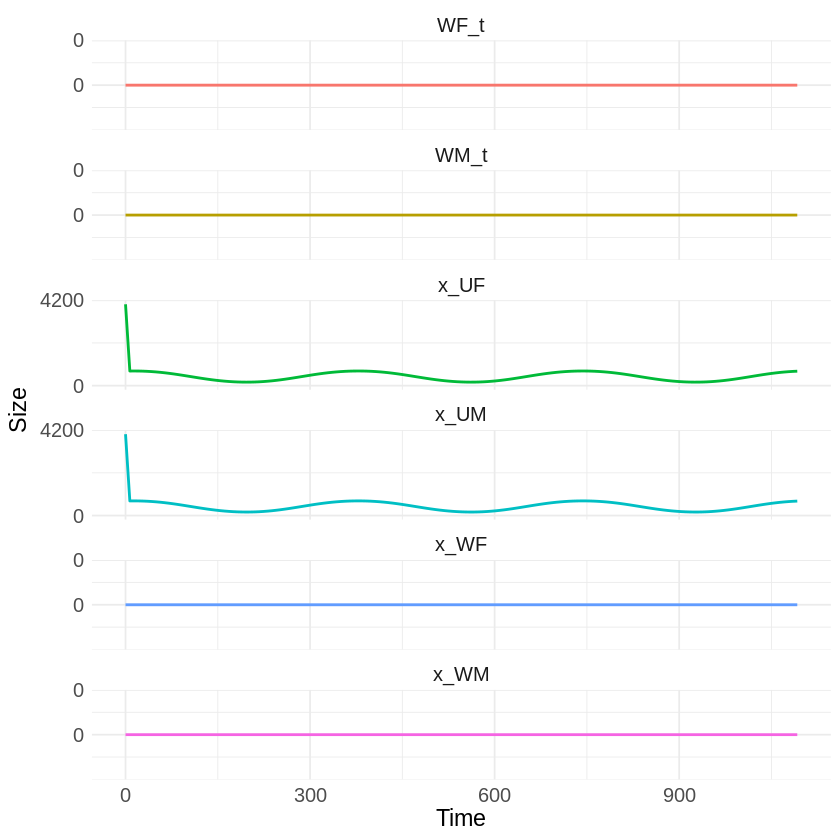

In [ ]:
# 1. Generar el gráfico con escala personalizada
plot <- as.data.frame(out) %>%
  pivot_longer(!time, names_to = "var", values_to = "size") %>%
  subset(var %in% c("x_UF", "x_UM", "x_WF", "x_WM", "WF_t", "WM_t")) %>%
  ggplot(aes(x = time, y = size, color = var)) +
  geom_line(linewidth = 0.8) +
  theme_minimal() +
  theme(
    legend.position = 'none',
    text = element_text(size = 12),
    axis.title = element_text(size = 14, ),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, )
  ) +
  facet_wrap(~var, scales = "free_y", ncol = 1) +
  labs(x = "Time", y = "Size") +
  scale_y_continuous(
    limits = c(0, NA),  # Fuerza el inicio en 0
    breaks = function(x) c(0, max(x)),  # Solo muestra 0 y el máximo
    labels = function(x) ifelse(x == 0, "0", round(x, 1))  # Formato: 0 y máximo con 1 decimal
  )

# Mostrar el gráfico
print(plot)

# 2. Guardar el gráfico
ggsave("mosquito_plot_simple.png", plot,
       width = 4, height = 3.2, dpi = 300, bg = "white")

In [ ]:
# 1. Definir modelo ----

# Definir función de modelo x'=f(x,u)

TSW_Model = function(times, x, parms, input)  {
  with(as.list(c(parms, x)), {
    ## Auxiliar
    # Vector and Matrix
    x_M = c(x_UM, x_WM)
    x_F = c(x_UF, x_WF)
    x   = c(x_UM, x_UF, x_WM, x_WF)
    e_4_1 = c(1, 0, 0, 0)
    e_4_2 = c(0, 1, 0, 0)
    e_4_3 = c(0, 0, 1, 0)
    e_4_4 = c(0, 0, 0, 1)
    e_2_1 = c(1, 0)
    e_2_2 = c(0, 1)
    o_4 = e_4_1 + e_4_2 + e_4_3 + e_4_4
    # o_4a = e_4_1*a_U + e_4_2 + e_4_3*a_U + e_4_4
    o_2 = e_2_1 + e_2_2
    G_U = matrix(c(1,  0,
                   1 - sigma, 0), nrow = 2, byrow = TRUE)
    G_W = matrix(c(0,  1,
                   0, 1), nrow = 2, byrow = TRUE)
    # Función bilinear de nacimientos
    b_U = (t(x_M) %*% G_U %*% x_F) / t(o_4) %*% x
    b_W = (t(x_M) %*% G_W %*% x_F) / t(o_4) %*% x
    # Operador de nacimientos
    Bx = c(b_U, b_U, b_W, b_W)
    # Seasonality of average temperature or constant
    s = s_seas * (A + B * cos(2 * pi * times / 365) + C * sin(2 * pi * times /
                                                                365)) + s_const * rep(25, length(times))
    #  the time-dependent oviposition rate mUM0_t, mUF0_t, mWM0_t, mWF0_t
    mUM0_t = mUM0_c * s * (s - mUM0_T0) * (mUM0_Tm - s) ^ (1 / 2)
    mUF0_t = mUF0_c * s * (s - mUF0_T0) * (mUF0_Tm - s) ^ (1 / 2)
    mWM0_t = (1 - m_w) * mWM0_c * s * (s - mWM0_T0) * (mWM0_Tm - s) ^ (1 /
                                                                         2)
    mWF0_t = (1 - m_w) * mWF0_c * s * (s - mWF0_T0) * (mWF0_Tm - s) ^ (1 /
                                                                         2)
    #
    mUM_t =  mUM0_t - mUM * t(o_4) %*% x
    mUF_t =  mUF0_t  - mUF * t(o_4) %*% x
    mWM_t =  mWM0_t - mWM * t(o_4) %*% x
    mWF_t =  mWF0_t - mWF * t(o_4) %*% x
    # Matriz diagonal reclutamiento
    m = matrix(
      c(mUM_t, 0, 0, 0,
        0, mUF_t, 0, 0,
        0, 0, mWM_t, 0,
        0, 0, 0, mWF_t),
      nrow = 4,
      byrow = TRUE
    )
    # time-dependent death rates of adult mosquitoes muUM0_t, muUF0_t, muWM0_t, muWF0_t
    muUM0_t = (muUM0_c * (s - muUM0_T0) * (muUM0_Tm - s)) ^ (-1)
    muUF0_t = (muUF0_c * (s - muUF0_T0) * (muUF0_Tm - s)) ^ (-1)
    muWM0_t = (1 + mu_w) * (muWM0_c * (s - muWM0_T0) * (muWM0_Tm - s)) ^
      (-1)
    muWF0_t = (1 + mu_w) * (muWF0_c * (s - muWF0_T0) * (muWF0_Tm - s)) ^
      (-1)
    muUM_t = muUM0_t + muUM * t(o_4) %*% x
    muUF_t = muUF0_t + muUM * t(o_4) %*% x
    muWM_t = muWM0_t + muUM * t(o_4) %*% x
    muWF_t = muWF0_t + muUM * t(o_4) %*% x
    # Matriz diagonal mortalidad
    mu = matrix(
      c(muUM_t, 0, 0, 0,
        0, muUF_t, 0, 0,
        0, 0, muWM_t, 0,
        0, 0, 0, muWF_t),
      nrow = 4,
      byrow = TRUE
    )
    # Import impulsive or const interval
    WM_t = WM * (impul * ifelse(-1 + 1 * cos(2 * pi * times / dd) < 0, 0, 1) + cont *
                   (times >= lowerM & times <= upperM))  # Machos infectados
    WF_t = WF * (impul * ifelse(-1 + 1 * cos(2 * pi * times / dd) < 0, 0, 1) + cont *
                   (times >= lowerF & times <= upperF)) # Hembras infectadass
    W = c(0, 0, WM_t, WF_t)
    # ODE System
    dx = m %*% Bx - mu %*% x + W
    res <- dx
    return(
      list(
        c(dx),
        s = s,
        WM_t = WM_t,
        WF_t = WF_t,
        mUM0_t = mUM0_t,
        mUF0_t = mUF0_t,
        mWM0_t = mWM0_t,
        mWF0_t = mWF0_t,
        muUM0_t = muUM0_t,
        muUF0_t = muUF0_t,
        muWM0_t = muWM0_t,
        muWF0_t = muWF0_t
      )
    )
  })
}


In [ ]:
# Configuración inicial de parámetros FIJOS
base_parms <- c(
  sigma = 1,
  m_w = 0.20,
  mu_w = 0.20,
  mUM0_c = 0.0058,
  mUF0_c = 0.0058,
  mWM0_c = 0.0058,
  mWF0_c = 0.0058,
  mUM0_T0 = 14.0343,
  mUF0_T0 = 14.0343,
  mWM0_T0 = 14.0343,
  mWF0_T0 = 14.0343,
  mUM0_Tm = 39.0899,
  mUF0_Tm = 39.0899,
  mWM0_Tm = 39.0899,
  mWF0_Tm = 39.0899,
  mUM = 0.0001,
  mUF = 0.0001,
  mWM = 0.0002,
  mWF = 0.0002,
  muUM0_c = 0.1037,
  muUF0_c = 0.1037,
  muWM0_c = 0.1037,
  muWF0_c = 0.1037,
  muUM0_T0 = 6.4429,
  muUF0_T0 = 6.4429,
  muWM0_T0 = 6.4429,
  muWF0_T0 = 6.4429,
  muUM0_Tm = 41.4382,
  muUF0_Tm = 41.4382,
  muWM0_Tm = 41.4382,
  muWF0_Tm = 41.4382,
  muUM = 0.0002,
  muUF = 0.0002,
  muWM = 0.0003,
  muWF = 0.0003
)

# Función para ejecutar simulación y devolver métricas
run_simulation_metrics <- function(parms, times, xstart, sigimp, scenario_id) {
  out <- deSolve::ode(
    y = xstart,
    times = times,
    func = TSW_Model,
    parms = parms,
    input = sigimp
  )

  out_df <- as.data.frame(out)

  # Calcular métricas clave
  metrics <- data.frame(
    scenario_id = scenario_id,
    final_WF = tail(out_df$x_WF, 1),
    final_UF = tail(out_df$x_UF, 1),
    final_WM = tail(out_df$x_WM, 1),
    final_UM = tail(out_df$x_UM, 1),
    max_WF = max(out_df$x_WF),
    max_UF = max(out_df$x_UF),
    time_to_establish = if(any(out_df$x_WF > 1000)) min(which(out_df$x_WF > 1000)) else NA,
    success = tail(out_df$x_WF, 1) > 1000  # Éxito si WF > 1000 al final
  )

  return(metrics)
}

# Configuración de escenarios
fechas <- c(15, 192, 275)  # días del año
estrategias <- c("10%","25%", "50%","75%","100%","reemplazo", "100%M")
duraciones <- c(30, 60)
# Configuración de parámetros biológicos (2 niveles cada uno)
sigma_values <- c(0.7, 0.8,0.9,1)
fertility_reduction <- c(0.15,0.20,0.25,0.30)
mortality_increase <- c(0.15, 0.30,0.45,0.6)

# [Mantener toda la configuración inicial igual...]

# Dataframes consolidados
all_metrics <- data.frame()
all_parameters <- data.frame()

scenario_id <- 1

# Ejecutar todas las simulaciones
for (fecha in fechas) {
  for (estrategia in estrategias) {
    for (duracion in duraciones) {
      for (sigma_val in sigma_values) {
        for (fert_val in fertility_reduction) {
          for (mort_val in mortality_increase) {

            # Configurar parámetros según estrategia
            parms <- base_parms
            parms["sigma"] <- sigma_val
            parms["m_w"] <- fert_val
            parms["mu_w"] <- mort_val

            if (estrategia == "10%") {
              parms["WM"] <- 4000 * 0.1
              parms["WF"] <- 4000 * 0.1
              parms["lowerM"] <- fecha
              parms["upperM"] <- fecha + duracion
              parms["lowerF"] <- fecha
              parms["upperF"] <- fecha + duracion

            } else if (estrategia == "25%") {
              parms["WM"] <- 4000 * 0.25
              parms["WF"] <- 4000 * 0.25
              parms["lowerM"] <- fecha
              parms["upperM"] <- fecha
              parms["lowerF"] <- fecha
              parms["upperF"] <- fecha + duracion

              } else if (estrategia == "50%") {
              parms["WM"] <- 4000 * 0.5
              parms["WF"] <- 4000 * 0.5
              parms["lowerM"] <- fecha
              parms["upperM"] <- fecha
              parms["lowerF"] <- fecha
              parms["upperF"] <- fecha + duracion

              } else if (estrategia == "75%") {
              parms["WM"] <- 4000 * 0.75
              parms["WF"] <- 4000 * 0.75
              parms["lowerM"] <- fecha
              parms["upperM"] <- fecha
              parms["lowerF"] <- fecha
              parms["upperF"] <- fecha + duracion

              } else if (estrategia == "100%") {
              parms["WM"] <- 4000 * 1
              parms["WF"] <- 4000 * 1
              parms["lowerM"] <- fecha
              parms["upperM"] <- fecha
              parms["lowerF"] <- fecha
              parms["upperF"] <- fecha + duracion

              } else if (estrategia == "reemplazo") {
              parms["WM"] <- 4000 * 0
              parms["WF"] <- 4000 * 1
              parms["lowerM"] <- fecha
              parms["upperM"] <- fecha
              parms["lowerF"] <- fecha
              parms["upperF"] <- fecha + duracion


            } else if (estrategia == "100%M") {
              parms["WM"] <- 4000 * 1
              parms["WF"] <- 4000 * 1
              parms["lowerM"] <- fecha
              parms["upperM"] <- fecha + duracion
              parms["lowerF"] <- fecha + 2
              parms["upperF"] <- fecha + duracion + 2
            }

            # ✅ GUARDAR PARÁMETROS (FALTABA ESTO)
            params_row <- data.frame(
              scenario_id = scenario_id,
              fecha_inicio = fecha,
              estrategia = estrategia,
              duracion_dias = duracion,
              sigma = sigma_val,
              fertilidad = fert_val,
              mortalidad = mort_val,
              WM_liberados = parms["WM"],
              WF_liberados = parms["WF"]
            )
            all_parameters <- rbind(all_parameters, params_row)

            # ✅ EJECUTAR SIMULACIÓN (FALTABA ESTO)
            metrics <- run_simulation_metrics(parms, times, xstart, sigimp, scenario_id)
            all_metrics <- rbind(all_metrics, metrics)

            # Mostrar progreso
            if (scenario_id %% 10 == 0) {
              cat("Ejecutando escenario", scenario_id, "de 2688...\n")
            }

            scenario_id <- scenario_id + 1
          }
        }
      }
    }
  }
}

# Guardar archivos consolidados
write.csv(all_parameters, "TODOS_los_parametros.csv", row.names = FALSE)
write.csv(all_metrics, "TODAS_las_metricas.csv", row.names = FALSE)

cat("✅ Simulaciones completadas! Archivos guardados.\n")

Ejecutando escenario 10 de 486...
Ejecutando escenario 20 de 486...
Ejecutando escenario 30 de 486...
Ejecutando escenario 40 de 486...
Ejecutando escenario 50 de 486...
Ejecutando escenario 60 de 486...
Ejecutando escenario 70 de 486...
Ejecutando escenario 80 de 486...
Ejecutando escenario 90 de 486...
Ejecutando escenario 100 de 486...
Ejecutando escenario 110 de 486...
Ejecutando escenario 120 de 486...
Ejecutando escenario 130 de 486...
Ejecutando escenario 140 de 486...
Ejecutando escenario 150 de 486...
Ejecutando escenario 160 de 486...
Ejecutando escenario 170 de 486...
Ejecutando escenario 180 de 486...
Ejecutando escenario 190 de 486...
Ejecutando escenario 200 de 486...
Ejecutando escenario 210 de 486...
Ejecutando escenario 220 de 486...
Ejecutando escenario 230 de 486...
Ejecutando escenario 240 de 486...
Ejecutando escenario 250 de 486...
Ejecutando escenario 260 de 486...
Ejecutando escenario 270 de 486...
Ejecutando escenario 280 de 486...
Ejecutando escenario 290 de 4

In [ ]:
# CARGAR Y ANALIZAR RESULTADOS - CÓDIGO ÚNICO
resultados <- read.csv("TODOS_los_parametros.csv") %>%
  merge(read.csv("TODAS_las_metricas.csv"), by = "scenario_id")

# VER ESTRUCTURA
cat("Dimensiones:", dim(resultados), "\n")
cat("Éxitos:", sum(resultados$success), "/", nrow(resultados), "\n\n")

# TABLA RESUMEN POR ESTRATEGIA
cat("TASA DE ÉXITO POR ESTRATEGIA:\n")
print(aggregate(success ~ estrategia, data = resultados, mean))

# TABLA RESUMEN POR FECHA
cat("\nTASA DE ÉXITO POR FECHA:\n")
print(aggregate(success ~ fecha_inicio, data = resultados, mean))

# MEJORES 5 ESCENARIOS
cat("\nMEJORES ESCENARIOS (mayor población final WF):\n")
mejores <- resultados[order(-resultados$final_WF), ][1:5, ]
print(mejores[, c("scenario_id", "estrategia", "fecha_inicio", "sigma", "final_WF", "success")])

# PEORES 5 ESCENARIOS
cat("\nPEORES ESCENARIOS (menor población final WF):\n")
peores <- resultados[order(resultados$final_WF), ][1:5, ]
print(peores[, c("scenario_id", "estrategia", "fecha_inicio", "sigma", "final_WF", "success")])

# GUARDAR PARA ANÁLISIS
write.csv(resultados, "ANALISIS_COMPLETO.csv", row.names = FALSE)
cat("\n✅ Archivo guardado: ANALISIS_COMPLETO.csv\n")

Dimensiones: 2688 17 
Éxitos: 1812 / 2688 

TASA DE ÉXITO POR ESTRATEGIA:
  estrategia   success
1        10% 0.3333333
2       100% 0.8671875
3      100%M 0.9895833
4        25% 0.3333333
5        50% 0.6197917
6        75% 0.7083333
7  reemplazo 0.8671875

TASA DE ÉXITO POR FECHA:
  fecha_inicio   success
1           15 0.3281250
2          192 1.0000000
3          275 0.6941964

MEJORES ESCENARIOS (mayor población final WF):
     scenario_id estrategia fecha_inicio sigma final_WF success
1137        1137        25%          192   1.0 3778.641    TRUE
817          817      100%M           15   1.0 3778.640    TRUE
1345        1345        75%          192   0.7 3778.635    TRUE
2609        2609      100%M          275   1.0 3778.634    TRUE
1393        1393        75%          192   1.0 3778.633    TRUE

PEORES ESCENARIOS (menor población final WF):
    scenario_id estrategia fecha_inicio sigma       final_WF success
235         235        25%           15   0.9 -7.230556e-137   FALSE

In [ ]:
# Cargar librerías necesarias
if (!require(openxlsx)) install.packages("openxlsx")
library(openxlsx)

# Cargar los archivos consolidados
parametros <- read.csv("TODOS_los_parametros.csv")
metricas <- read.csv("TODAS_las_metricas.csv")

# Unir toda la información
resultados_completos <- merge(metricas, parametros, by = "scenario_id")

# Crear un libro de Excel con múltiples hojas
wb <- createWorkbook()

# Hoja 1: Todos los resultados
addWorksheet(wb, "TODAS_144_SIMULACIONES")
writeData(wb, "TODAS_144_SIMULACIONES", resultados_completos)

# Hoja 2: Solo escenarios exitosos
exitosos <- resultados_completos[resultados_completos$success == TRUE, ]
addWorksheet(wb, "SOLO_EXITOSOS")
writeData(wb, "SOLO_EXITOSOS", exitosos)

# Hoja 3: Resumen estadístico
resumen <- aggregate(success ~ estrategia + fecha_inicio,
                    data = resultados_completos,
                    function(x) c(Exitos = sum(x), Total = length(x), Tasa = mean(x)))
addWorksheet(wb, "RESUMEN")
writeData(wb, "RESUMEN", resumen)

# Guardar archivo Excel
saveWorkbook(wb, "RESULTADOS_486_SIMULACIONES.xlsx", overwrite = TRUE)

cat("✅ Archivo Excel creado: RESULTADOS_486_SIMULACIONES.xlsx\n")
cat("📊 Contenido:\n")
cat("   - Hoja 1: Todas las 486 simulaciones\n")
cat("   - Hoja 2: Solo", nrow(exitosos), "escenarios exitosos\n")
cat("   - Hoja 3: Resumen por estrategia y fecha\n")
cat("   - Total filas:", nrow(resultados_completos), "\n")

Loading required package: openxlsx

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘openxlsx’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✅ Archivo Excel creado: RESULTADOS_486_SIMULACIONES.xlsx
📊 Contenido:
   - Hoja 1: Todas las 486 simulaciones
   - Hoja 2: Solo 1336 escenarios exitosos
   - Hoja 3: Resumen por estrategia y fecha
   - Total filas: 2016 
